In [1]:
%%capture
!pip install "datasets==3.6.0" -q
!git clone https://github.com/huutrank4ds/vi-tacotron2.git -q

import sys
sys.path.append('/kaggle/working/vi-tacotron2')

In [2]:
from huggingface_hub import login

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# login với secret
login(token=user_secrets.get_secret("HF_TOKEN"))

In [13]:
from model import Tacotron2
import torch
import os 
from config import Hparams as TacotronParams
from utils import load_checkpoint_chunk
from processing import PrepareTextMel

hparams = TacotronParams()
hparams.name_file_checkpoint = 'checkpoint_epoch_3_chunk_4.pt'
hparams.checkpoint_path = '/kaggle/input/checkpoints-vi-tacotron2/pytorch/default/15'
hparams.n_frames_per_step = 2
hparams.encoder_dropout = 0



model = Tacotron2(hparams)
prepare = PrepareTextMel(hparams)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
checkpoint_path = os.path.join(hparams.checkpoint_path, hparams.name_file_checkpoint)
checkpoint_param = load_checkpoint_chunk(checkpoint_path, model, device)

# checkpoint_dict = torch.load(checkpoint_path, map_location=device)
# state_dict = checkpoint_dict['model_state_dict']
# keys_to_change = []
# for key in state_dict.keys():
#     if "speaker_projection.2." in key:
#         keys_to_change.append(key)
        
# for key in keys_to_change:
#     new_key = key.replace("speaker_projection.2.", "speaker_projection.3.")
#     state_dict[new_key] = state_dict.pop(key)
#     print(f"Migrated key: {key} -> {new_key}")
# model.load_state_dict(state_dict)

In [4]:
import torch
speaker_embeddings_path = '/kaggle/input/mean-speaker-embeddings-phoaudiobook/mean_speaker_embeddings.pt'
mean_speaker_embeddings = torch.load(speaker_embeddings_path)
speaker_map = mean_speaker_embeddings['speaker_map']
embeddings = mean_speaker_embeddings['mean_embeddings']

# Cách chuẩn
speaker_to_embs = {
    name: embeddings[spk_id] 
    for spk_id, name in speaker_map.items()
}

In [14]:
import torch

text = 'ngày xửa ngày xưa, có một chàng trai nghèo sống cùng với mẹ của mình. một hôm chàng trai đi ra đường và gặp một chuyện lạ.'
text_inputs = prepare.prosessing_text(text, device)

speaker = 'Văn_Hoàng'
speaker_embeddings = speaker_to_embs[speaker].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(text_inputs, speaker_embeddings)

Warning! Reached max decoder steps


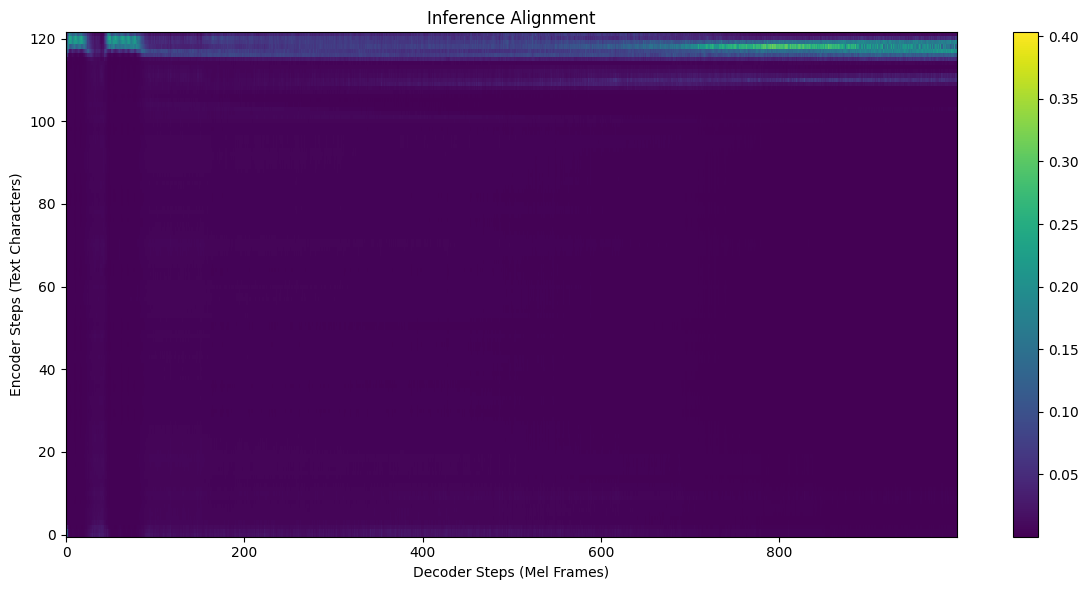

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_alignment(alignment, title="Alignment"):
    """
    Vẽ biểu đồ Alignment (Attention) và hiển thị trực tiếp.
    alignment: numpy array 2D
    """
    # Tạo một figure mới hoàn toàn
    fig = plt.figure(figsize=(12, 6)) 
    
    plt.imshow(alignment, aspect='auto', origin='lower', interpolation='nearest')
    
    plt.xlabel('Decoder Steps (Mel Frames)')
    plt.ylabel('Encoder Steps (Text Characters)')
    plt.title(title)
    plt.colorbar() 
    
    plt.tight_layout()
    plt.show() # Hiển thị ảnh
    
    # [QUAN TRỌNG] Đóng figure để giải phóng bộ nhớ cho lần vẽ sau
    plt.close(fig) 

alignment_data = alignments[0].data.cpu().numpy() # Kết quả: [654, 122] (2 chiều)
if alignment_data.shape[0] > alignment_data.shape[1]:
    alignment_data = alignment_data.T # Xoay thành [122,
plot_alignment(alignment_data, title="Inference Alignment")
plt.show()

In [7]:
!git clone https://github.com/jik876/hifi-gan.git -q

# 1. Đổi tên folder
!mv hifi-gan hifi_gan

# 2. Tạo __init__.py
!touch hifi_gan/__init__.py

# 3. Sửa import trong models.py từ "from utils" thành "from .utils" (thêm dấu chấm)
!sed -i 's/from utils/from .utils/g' hifi_gan/models.py
!sed -i 's/from env/from .env/g' hifi_gan/models.py

In [8]:
# BÂY GIỜ IMPORT SẼ NHƯ SAU (Không cần sys.path.append nữa):
from hifi_gan.models import Generator
import torch
import json
import sys
import os
from hifi_gan.models import Generator  # Import class Generator từ repo hifi-gan
from hifi_gan.env import AttrDict

def load_hifigan(checkpoint_path, config_path, device='cuda'):
    # 1. Load Config
    with open(config_path) as f:
        data = f.read()
    json_config = json.loads(data)
    h = AttrDict(json_config)

    # 2. Khởi tạo Model
    # HiFi-GAN Generator nhận tham số cấu hình 'h'
    generator = Generator(h).to(device)

    # 3. Load Checkpoint Weights
    state_dict_g = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(state_dict_g['generator'])

    # 4. Chuyển sang chế độ đánh giá (cực kỳ quan trọng để tắt Dropout)
    generator.eval()
    generator.remove_weight_norm() # Giúp chạy nhanh hơn
    
    return generator, h

def inference(generator, mel_spectrogram, device='cuda'):
    """
    mel_spectrogram shape: [Batch, Num_Mels, Time]
    Ví dụ: [1, 80, 500]
    """
    with torch.no_grad():
        mel = mel_spectrogram.to(device)
        
        # Chạy qua model
        # audio output shape: [Batch, 1, Time * Hop_Length]
        audio = generator(mel)
        
        # Squeeze để bỏ chiều channel -> [Batch, Time_Samples]
        audio = audio.squeeze(1)
        
    return audio

In [9]:
# --- SỬ DỤNG ---
# Đường dẫn file (Thay đổi theo đường dẫn thực tế của bạn)
ckpt_path = "/kaggle/input/checkpoint-hifigan-universal-v1/pytorch/default/1/UNIVERSAL_V1/g_02500000" # File checkpoint
conf_path = "/kaggle/input/checkpoint-hifigan-universal-v1/pytorch/default/1/UNIVERSAL_V1/config.json"  # File config

vocoder, hparams = load_hifigan(ckpt_path, conf_path, device)

# Chạy Inference
generated_audio = inference(vocoder, mel_outputs, device)

print(f"Audio shape: {generated_audio.shape}") 
# Kết quả sẽ là [1, 500 * hop_size]

# Lưu file nghe thử
import torchaudio
torchaudio.save("output_hifigan.wav", generated_audio.cpu(), hparams.sampling_rate)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Removing weight norm...
Audio shape: torch.Size([1, 512000])


In [10]:
import torch
import IPython.display as ipd
import numpy as np

def play_audio(audio_tensor, sample_rate):
    """
    audio_tensor: Tensor đầu ra từ HiFi-GAN (thường ở GPU)
    sample_rate: Tần số lấy mẫu (ví dụ 22050)
    """
    audio_np = audio_tensor.detach().cpu().squeeze().numpy()
    
    if np.abs(audio_np).max() > 1.0:
        audio_np = audio_np / np.abs(audio_np).max()
    
    return ipd.Audio(audio_np, rate=sample_rate, normalize=False)

play_audio(generated_audio, 22050)